In [34]:
import sys
import numpy as np
import pandas as pd
import imageio # Import the imageio package
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

# Import BatchNormalization directly from keras.layers
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

### Please give below paths as per the paths in your system

In [35]:
train_folder = "./images_background/"
val_folder = './images_evaluation/'
save_path = './data/'

In [36]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = cv2.imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

### Loading the train images into tensors

In [37]:
X,y,c=loadimgs(train_folder)

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Burmese_(Myanmar)
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tagalog
loading alphabet: Tifinagh


### Saving the train tensors on disk

In [38]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

### Loading the validation images into tensors

In [39]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: Angelic
loading alphabet: Atemayar_Qelisayer
loading alphabet: Atlantean
loading alphabet: Aurek-Besh
loading alphabet: Avesta
loading alphabet: Ge_ez
loading alphabet: Glagolitic
loading alphabet: Gurmukhi
loading alphabet: Kannada
loading alphabet: Keble
loading alphabet: Malayalam
loading alphabet: Manipuri
loading alphabet: Mongolian
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Oriya
loading alphabet: Sylheti
loading alphabet: Syriac_(Serto)
loading alphabet: Tengwar
loading alphabet: Tibetan
loading alphabet: ULOG


### Saving the validation tensors on disk

In [40]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [41]:
# del X, y ,c ,Xval, yval, cval

In [42]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [43]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [44]:
def initialize_weights(shape, dtype=None):
    return np.random.normal(loc=0.0, scale=1e-2, size=shape)

def initialize_bias(shape, dtype=None):
    return np.random.normal(loc=0.5, scale=1e-2, size=shape)


In [45]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]), output_shape=(4096,))
    L1_distance = L1_layer([encoded_l, encoded_r])

    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [46]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import numpy as np

In [47]:

def get_siamese_model(input_shape=(105, 105, 3)):  # Changed to (105, 105, 3)
    """
    Model architecture for Siamese network handling RGB images.
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7, 7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4, 4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4, 4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                    kernel_regularizer=l2(1e-3),
                    kernel_initializer=initialize_weights, bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid', bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    # return the model
    return siamese_net

In [48]:
model = get_siamese_model((105, 105, 1))
model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 4096)      │ 38,947,648 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 4096)      │          0 │ sequential_2[0][… │
│                     │                   │            │ sequential_2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      4,097 │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,951,745 (148.59 MB)

 Trainable params: 38,951,745 (148.59 MB)

 Non-trainable params: 0 (0.00 B)

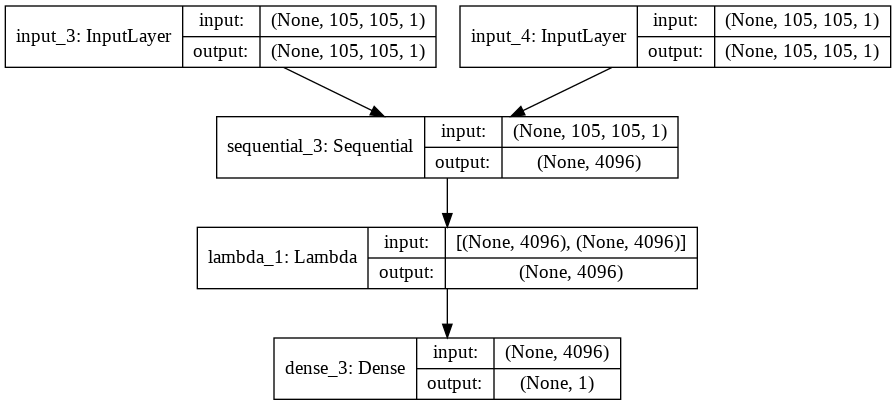

In [49]:
from IPython.display import Image
Image(retina=True, filename='./image.png')

In [50]:
optimizer = Adam(learning_rate=0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

### Loading the train tensors

In [51]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']


In [52]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG']


In [53]:
def get_batch(batch_size, s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
        
    n_classes, n_examples, w, h, d = X.shape  # Note: added 'd' for the 3 channels (RGB)

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes, size=(batch_size,), replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, d)) for i in range(2)]  # Changed 1 to d
    
    # initialize vector for the targets
    targets = np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size // 2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, d)  # Changed to 'd' channels
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else:
            # add a random number to the category modulo n_classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1, n_classes)) % n_classes
        
        pairs[1][i, :, :, :] = X[category_2, idx_2].reshape(w, h, d)  # Changed to 'd' channels
    
    return pairs, targets



In [54]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [55]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [56]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [57]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [58]:
model_path = './weights/'

In [59]:
print(X.shape)


(964, 20, 105, 105, 3)


In [60]:
import numpy as np
import cv2  # OpenCV for resizing images

def resize_image(image, target_size):
    """Resize the image to the target size."""
    if image is None or not hasattr(image, 'shape'):
        raise ValueError("Input image is invalid.")
    
    if target_size <= 0:
        raise ValueError("Target size must be a positive integer.")
    
    print(f"Resizing image from shape {image.shape} to ({target_size}, {target_size})")
    
    # Ensure the target size is not empty
    if target_size <= 0:
        raise ValueError("Target size must be a positive integer.")
    
    # Resize the image
    resized_image = cv2.resize(image, (target_size, target_size))
    
    if resized_image is None or resized_image.size == 0:
        raise ValueError("Resizing failed, resulting image is empty.")
    
    return resized_image

def test_oneshot(model, N, k, s="val", verbose=0):
    """Test average N way one-shot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    target_size = 105  # Target size for resizing
    
    if verbose:
        print(f"Evaluating model on {k} random {N} way one-shot learning tasks ... \n")

    for i in range(k):
        inputs, targets = make_oneshot_task(N, s)
        
        # Ensure inputs are valid
        if isinstance(inputs, tuple) and len(inputs) == 2:
            # Resize images
            try:
                inputs = (resize_image(inputs[0], target_size), resize_image(inputs[1], target_size))
                probs = model.predict(inputs)
            except ValueError as e:
                print(f"Error resizing images: {e}")
                continue
        else:
            try:
                inputs = resize_image(inputs, target_size)
                # If the model expects two inputs, provide the resized image twice
                probs = model.predict([inputs, inputs])
            except ValueError as e:
                print(f"Error resizing image: {e}")
                continue
        
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1

    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print(f"Got an average of {percent_correct}% {N} way one-shot learning accuracy \n")
    return percent_correct


In [61]:
def test_oneshot(model, N, k, s="val", verbose=0):
    """Test average N way one-shot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print(f"Evaluating model on {k} random {N} way one-shot learning tasks ... \n")

    for i in range(k):
        inputs, targets = make_oneshot_task(N, s)
        
        # If the model expects two inputs, prepare them accordingly
        if isinstance(inputs, tuple) and len(inputs) == 2:
            # Predict with two inputs
            probs = model.predict(inputs)
        else:
            # Handle case for a model with a single input
            probs = model.predict([inputs])
        
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1

    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print(f"Got an average of {percent_correct}% {N} way one-shot learning accuracy \n")
    return percent_correct


In [62]:
model.compile(
    optimizer=Adam(),                  # Optimizer (e.g., Adam, SGD, etc.)
    loss='binary_crossentropy',        # Loss function (e.g., binary_crossentropy, categorical_crossentropy, etc.)
    metrics=['accuracy']               # Metrics to monitor
)

In [63]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()

for i in range(1, n_iter + 1):
    # Fetch a batch of data
    inputs, targets = get_batch(batch_size)
    print(f"Inputs shape: {inputs[0].shape}, {inputs[1].shape}")
    
    # Train the model on the current batch
    loss = model.train_on_batch(inputs, targets)
    
    if i % evaluate_every == 0:
        elapsed_time = (time.time() - t_start) / 60.0
        print("\n ------------- \n")
        print(f"Time for {i} iterations: {elapsed_time:.2f} mins")
        print(f"Train Loss: {loss}")

        # Evaluate validation accuracy
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        
        # Save model weights
        model.save_weights(os.path.join(model_path, f'{i}.weights.h5'))
        
        # Update and print best validation accuracy if applicable
        if val_acc >= best:
            print(f"Current best: {val_acc}, previous best: {best}")
            best = val_acc


Starting training process!
-------------------------------------
Inputs shape: (32, 105, 105, 3), (32, 105, 105, 3)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_8" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (32, 105, 105, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 105, 105, 3), dtype=float32)
  • training=True
  • mask=None

### Load model weights

In [88]:
model.load_weights(os.path.join(model_path, "20000.weights.h5"))

### Testing

### Baseline model based on Nearest Neighbors using Euclidean distance (L2 distance)

In [89]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [90]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [91]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [103]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Resizing image from shape (1, 20, 32, 32) to (105, 105)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:3789: error: (-215:Assertion failed) !dsize.empty() in function 'cv::hal::resize'


### Save the accuracies on disk

In [36]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

### Load the accuracies from disk

In [20]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

### Below two functions are used for visualizing test image and support set

In [21]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [22]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

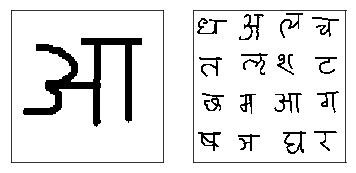

In [40]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
plot_oneshot_task(pairs)

### Resuts

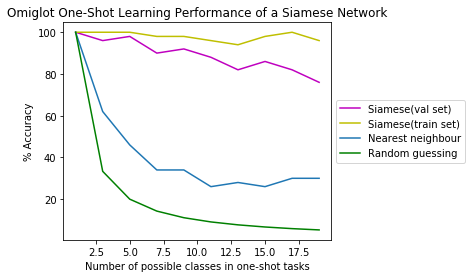

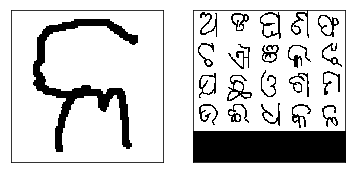

In [41]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)